In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icecube-neutrinos-in-deep-ice/train_meta.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/sample_submission.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/test_meta.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv
/kaggle/input/icecube-neutrinos-in-deep-ice/test/batch_661.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_240.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_295.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_158.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_35.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_145.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_476.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_449.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_104.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_419.parquet
/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_136.par

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import multiprocessing

In [3]:
############## plotly no show... - fixer code! #############
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [4]:
def count_batches(path):
    counter = 0
    for item in path.glob('*'):
        if item.is_file():
            counter +=1
    return counter

data_path = Path("/kaggle/input/icecube-neutrinos-in-deep-ice/")
print(f'Batches in train folder: {count_batches(data_path / "train")}')
print(f'Batches in test folder: {count_batches(data_path / "test")}')

Batches in train folder: 660
Batches in test folder: 1


In [5]:
train_batch = pd.read_parquet(data_path / "train" / "batch_1.parquet")
print(f"Shape: {train_batch.shape}")
train_batch.head()

Shape: (32792416, 4)


,sensor_id,time,charge,auxiliary
event_id,,,,
24,3918,5928,1.325,True
24,4157,6115,1.175,True
24,3520,6492,0.925,True
24,5041,6665,0.225,True
24,2948,8054,1.575,True


In [6]:
print(f"Events in first batch: {train_batch.index.nunique()}")

Events in first batch: 200000


In [7]:
pulses_in_batch = pd.DataFrame(train_batch.groupby('event_id').size(), columns=["n_pulses"])

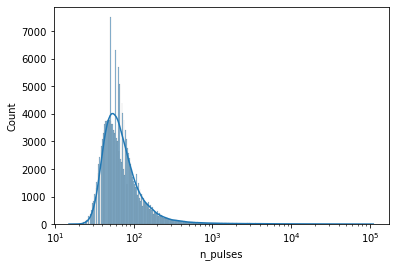

In [8]:
sns.histplot(pulses_in_batch, x='n_pulses', log_scale=True, kde=True) #title="Number of Pulses in Event (log scale)")
plt.show()

In [9]:
event_time_length = pd.DataFrame(train_batch.groupby('event_id')['time'].agg(np.ptp))

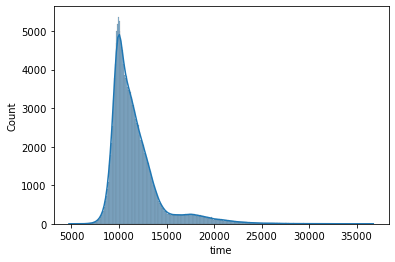

In [10]:
sns.histplot(event_time_length, x="time", kde=True)
plt.show()

In [11]:
train_meta = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/train_meta.parquet')
print('Total number of events in meta: ' + str(len(train_meta)))
train_meta.head()

Total number of events in meta: 131953924


,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
0,1,24,0,60,5.029555,2.087498
1,1,41,61,111,0.417742,1.549686
2,1,59,112,147,1.160466,2.401942
3,1,67,148,289,5.845952,0.759054
4,1,72,290,351,0.653719,0.939117


In [12]:
train_batch_1 = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_1.parquet')
print(str(len(train_batch_1)), ' events and ', str(len(train_batch_1.index.unique())), ' pulses in batch 1')
train_batch_1.head()

32792416  events and  200000  pulses in batch 1


,sensor_id,time,charge,auxiliary
event_id,,,,
24,3918,5928,1.325,True
24,4157,6115,1.175,True
24,3520,6492,0.925,True
24,5041,6665,0.225,True
24,2948,8054,1.575,True


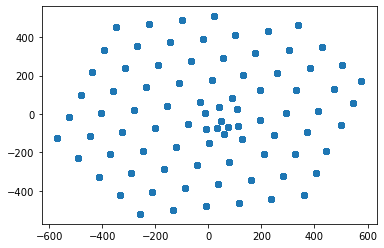

,sensor_id,x,y,z
0,0,-256.14,-521.08,496.03
1,1,-256.14,-521.08,479.01
2,2,-256.14,-521.08,461.99
3,3,-256.14,-521.08,444.97
4,4,-256.14,-521.08,427.95


In [13]:
sensor_geometry = pd.read_csv('/kaggle/input/icecube-neutrinos-in-deep-ice/sensor_geometry.csv')
plt.scatter(sensor_geometry.x, sensor_geometry.y)
plt.show()
sensor_geometry.head()

In [14]:
fig = px.scatter_3d(sensor_geometry, x='x', y='y', z='z', opacity=0.4)
fig.update_traces(marker_size=2)
fig.show()

In [15]:
test_meta = pd.read_parquet('/kaggle/input/icecube-neutrinos-in-deep-ice/test_meta.parquet')
test_meta.head()

,batch_id,event_id,first_pulse_index,last_pulse_index
0,661,2092,0,298
1,661,7344,299,334
2,661,9482,335,377


# Case Event

Exploring event 67 (number three in train_meta) as a case event

In [16]:
case_event_idx = 3
case_event_pulses = train_batch_1.iloc[train_meta.iloc[case_event_idx].first_pulse_index.astype(int) : 
                                         train_meta.iloc[case_event_idx].last_pulse_index.astype(int)+1].copy()
print(f'Case event with index #{3} has {len(case_event_pulses)} pluses')
case_event_pulses.tail()

Case event with index #3 has 142 pluses


,sensor_id,time,charge,auxiliary
event_id,,,,
67,1890,26683,1.675,True
67,3624,26961,1.075,True
67,1928,27065,1.075,True
67,4680,27100,0.425,True
67,3772,27144,1.475,True


In [17]:
#The coordinates of each pulse from the sensor geometry data and mean normalizing

case_event_pulses = case_event_pulses.reset_index()
case_event_pulses[['x', 'y', 'z']] = sensor_geometry.loc[case_event_pulses.sensor_id].reset_index()[['x', 'y', 'z']]

case_event_pulses.x = case_event_pulses.x - case_event_pulses.x.mean()
case_event_pulses.y = case_event_pulses.y - case_event_pulses.y.mean()
case_event_pulses.z = case_event_pulses.z - case_event_pulses.z.mean()
case_event_pulses.head()

,event_id,sensor_id,time,charge,auxiliary,x,y,z
0,67,5060,6751,0.675,True,38.258521,-16.083732,-165.493873
1,67,2420,7308,0.575,True,-478.691479,47.816268,223.256127
2,67,2420,7320,0.875,True,-478.691479,47.816268,223.256127
3,67,1968,7377,0.425,True,-276.451479,-30.013732,-255.853873
4,67,2989,7655,1.375,True,624.308521,234.336268,-278.963873


## Taking a look at the target

In [18]:
zenith_target = train_meta.iloc[case_event_idx].zenith
azimuth_target = train_meta.iloc[case_event_idx].azimuth

vector_target = [np.cos(azimuth_target) * np.sin(zenith_target), np.sin(azimuth_target) * np.sin(zenith_target),
                 np.cos(zenith_target)]

vector_base = np.array([-500, 500])
x = vector_base*vector_target[0]
y = vector_base*vector_target[1]
z = vector_base*vector_target[2]
vector_target_df = pd.DataFrame({'x': x, 'y': y, 'z': z})
vector_target_df.head()

,x,y,z
0,-311.74527,145.711308,-362.743851
1,311.74527,-145.711308,362.743851


In [19]:
fig_auxiliary = px.scatter_3d(case_event_pulses.loc[case_event_pulses.auxiliary],
                              x='x', y='y', z='z', opacity=0.5, color_discrete_sequence=['salmon'])
fig_non_auxiliary = px.scatter_3d(case_event_pulses.loc[~case_event_pulses.auxiliary],
                              x='x', y='y', z='z', opacity=0.5, color_discrete_sequence=['blue'])
fig_line = px.line_3d(vector_target_df, x="x", y="y", z="z")


fig_auxiliary.update_traces(marker_size=2)
fig_non_auxiliary.update_traces(marker_size=2)

fig = go.Figure(data = fig_auxiliary.data + fig_non_auxiliary.data + fig_line.data)
fig.show()

Most non-auxiliary pulses appear as a short vertical line of close dots, not because they come straight from the top but due to the structure of the detector.

### Naive Fitting - Just using the first principle component as the neutrino's direction
Only using the non-auxiliary pulses

In [20]:
pca = PCA(n_components=1).fit(case_event_pulses[['x', 'y', 'z']])
vector = pca.components_[0]
vector_base = np.array([-500, 500])
x = vector_base*vector[0]
y = vector_base*vector[1]
z = vector_base*vector[2]
vector_df = pd.DataFrame({'x': x, 'y': y, 'z': z})

fig_auxiliary = px.scatter_3d(case_event_pulses.loc[case_event_pulses.auxiliary],
                              x='x', y='y', z='z', opacity=0.5, color_discrete_sequence=['salmon'])
fig_non_auxiliary = px.scatter_3d(case_event_pulses.loc[~case_event_pulses.auxiliary],
                              x='x', y='y', z='z', opacity=0.5, color_discrete_sequence=['blue'])
fig_line = px.line_3d(vector_target_df, x="x", y="y", z="z")
fig_fit_line = px.line_3d(vector_df, x="x", y="y", z="z", color_discrete_sequence=['green'])

fig_auxiliary.update_traces(marker_size=2)
fig_non_auxiliary.update_traces(marker_size=2)

fig = go.Figure(data = fig_auxiliary.data + fig_non_auxiliary.data + fig_line.data + fig_fit_line.data)
fig.show()

In [21]:
def angular_dist_score(az_true, zen_true, az_pred, zen_pred):
    '''
    calculate the MAE of the angular distance between two directions.
    The two vectors are first converted to cartesian unit vectors,
    and then their scalar product is computed, which is equal to
    the cosine of the angle between the two vectors. The inverse 
    cosine (arccos) thereof is then the angle between the two input vectors
    
    Parameters:
    -----------
    
    az_true : float (or array thereof)
        true azimuth value(s) in radian
    zen_true : float (or array thereof)
        true zenith value(s) in radian
    az_pred : float (or array thereof)
        predicted azimuth value(s) in radian
    zen_pred : float (or array thereof)
        predicted zenith value(s) in radian
    
    Returns:
    --------
    
    dist : float
        mean over the angular distance(s) in radian
    '''
    
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    
    # pre-compute all sine and cosine values
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)
    
    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)
    
    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    
    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod =  np.clip(scalar_prod, -1, 1)
    
    # convert back to an angle (in radian)
    return np.average(np.abs(np.arccos(scalar_prod)))

In [22]:
zenith = np.arccos(vector[2])
azimuth = np.arctan2(vector[1], vector[0])
if azimuth<0:
    azimuth = 2*np.pi + azimuth

print('Predictions:')
print(f'Zenith: {zenith}')
print(f'Azimuth: {azimuth}')
print('Target:')
print(f'Zenith: {zenith_target}')
print(f'Azimuth: {azimuth_target}')
print('Error:')
print(angular_dist_score(azimuth_target, zenith_target, azimuth, zenith))

Predictions:
Zenith: 0.5955780199750245
Azimuth: 5.656874481284984
Target:
Zenith: 0.7590535704990591
Azimuth: 5.845951997240071
Error:
0.2014039002172295


## Baseline Validation

Strategy = fit a vector through only the 'true' pulses if there are enough (>12). Otherwise, vector fit with all the data. 

Additionally, calculate the average time of the 'true' pulses on the negative and positive sides of the vector and flip its direction if it points to the wrong one. 
As **lower times should be on the positive side since it is supposed to point to the source of the neutrino.** 
Only for the 'true' pulses, since the auxiliary pulse times are too noisy for this analysis without further refinement.

In [23]:
train_batches = train_meta.batch_id.unique()
train_meta_baseline = train_meta.loc[train_meta.batch_id == train_batches[0]].iloc[:10000].copy()
train_meta_baseline.tail()

,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith
9995,1,162626,1671200,1671237,3.069378,1.391397
9996,1,162642,1671238,1671278,3.218774,0.215064
9997,1,162663,1671279,1671397,2.099799,2.459361
9998,1,162670,1671398,1671513,3.462833,1.707639
9999,1,162703,1671514,1671723,4.081974,2.054623


In [24]:
train_baseline = pd.read_parquet(f'/kaggle/input/icecube-neutrinos-in-deep-ice/train/batch_{str(train_batches[0])}.parquet')
train_baseline = train_baseline.iloc[:train_meta_baseline.iloc[-1].last_pulse_index.astype(int)]
train_baseline = train_baseline.reset_index()
train_baseline[['x', 'y', 'z']] = sensor_geometry.loc[train_baseline.sensor_id].reset_index()[['x', 'y', 'z']]

train_baseline['x'] = train_baseline['x'] - train_baseline.groupby('event_id').x.transform('mean')
train_baseline['y'] = train_baseline['y'] - train_baseline.groupby('event_id').y.transform('mean')
train_baseline['z'] = train_baseline['z'] - train_baseline.groupby('event_id').z.transform('mean')

print(len(train_baseline))
train_baseline.head()

1671723


,event_id,sensor_id,time,charge,auxiliary,x,y,z
0,24,3918,5928,1.325,True,291.498033,364.956393,180.170984
1,24,4157,6115,1.175,True,-157.361967,403.556393,186.320984
2,24,3520,6492,0.925,True,493.358033,287.196393,-201.009016
3,24,5041,6665,0.225,True,-21.591967,-50.183607,154.590984
4,24,2948,8054,1.575,True,564.458033,200.236393,331.470984


In [25]:
import gc
gc.collect()

3390

In [26]:
def get_angles(event_df):   

    # Threshold number of non-auxillary pulses
    if len(event_df.loc[~event_df.auxiliary]) > 12:    
        pca = PCA(n_components=2).fit(event_df.loc[~event_df.auxiliary][['x', 'y', 'z']])
    else:
        pca = PCA(n_components=2).fit(event_df[['x', 'y', 'z']])
    vector = pca.components_[0]
    
    # In order to perform time direction analysis on the non-auxiliary ('true') pulses, we neeed to mean-normalize them separately
    event_df_non_auxiliary = event_df.loc[~event_df.auxiliary].copy()
    event_df_non_auxiliary.x = event_df_non_auxiliary.x - event_df_non_auxiliary.x.mean()
    event_df_non_auxiliary.y = event_df_non_auxiliary.y - event_df_non_auxiliary.y.mean()
    event_df_non_auxiliary.z = event_df_non_auxiliary.z - event_df_non_auxiliary.z.mean()
    
    # This is the formula for calculating a distance of a point from a plane. The plane direction is the first principal component, and it goes through the origin.
    event_df_non_auxiliary['distance'] = (event_df_non_auxiliary.x*vector[0]+
                                          event_df_non_auxiliary.y*vector[1]+
                                          event_df_non_auxiliary.z*vector[2])/np.linalg.norm(vector)
    
    # Flip the vector direction if it points away from the neutrino origin
    if (event_df_non_auxiliary.loc[(~event_df_non_auxiliary.auxiliary)&(event_df_non_auxiliary.distance>0)].time.mean() >
        event_df_non_auxiliary.loc[(~event_df_non_auxiliary.auxiliary)&(event_df_non_auxiliary.distance<0)].time.mean()):
        vector = -1*vector
    
    # This is important since minor numerical deviations can give a vector component like 1.00001, and then arccos fail.
    vector = np.clip(vector, -1, 1)
    
    zenith = np.arccos(vector[2])
    azimuth = np.arctan2(vector[1], vector[0])
    if azimuth<0:
        azimuth = 2*np.pi + azimuth
    return zenith, azimuth

In [27]:
%%time

train_meta_baseline[['azimuth_pred', 'zenith_pred']] = None
for i in range(len(train_meta_baseline)):
    row = train_meta_baseline.iloc[i]
    event_df = train_baseline.iloc[row.first_pulse_index.astype(int):row.last_pulse_index.astype(int)+1].copy()
    zenith, azimuth = get_angles(event_df)
    train_meta_baseline.loc[i, 'zenith_pred'] = zenith
    train_meta_baseline.loc[i, 'azimuth_pred'] = azimuth
    
train_meta_baseline.head()

CPU times: user 2min 5s, sys: 32.5 s, total: 2min 38s
Wall time: 1min 43s


,batch_id,event_id,first_pulse_index,last_pulse_index,azimuth,zenith,azimuth_pred,zenith_pred
0,1,24,0,60,5.029555,2.087498,1.664993,2.633781
1,1,41,61,111,0.417742,1.549686,1.546342,0.85832
2,1,59,112,147,1.160466,2.401942,3.141593,3.141593
3,1,67,148,289,5.845952,0.759054,5.722435,0.858858
4,1,72,290,351,0.653719,0.939117,5.992344,0.384247


In [28]:
angular_dist_score(train_meta_baseline.azimuth.to_numpy(), train_meta_baseline.zenith.to_numpy(),
                   train_meta_baseline.azimuth_pred.astype(float).to_numpy(),
                   train_meta_baseline.astype(float).zenith_pred.to_numpy())

1.2629562550904812

In [29]:
del train_meta_baseline,train_baseline, train_batch_1, train_meta
gc.collect()

42

In [30]:
def load_test_batch(test_batch_id):
    test_batch = pd.read_parquet(f'/kaggle/input/icecube-neutrinos-in-deep-ice/test/batch_{str(int(test_batch_id))}.parquet')
    test_batch = test_batch.reset_index()
    test_batch[['x', 'y', 'z']] = sensor_geometry.loc[test_batch.sensor_id].reset_index()[['x', 'y', 'z']]
    test_batch['x'] = test_batch['x'] - test_batch.groupby('event_id').x.transform('mean')
    test_batch['y'] = test_batch['y'] - test_batch.groupby('event_id').y.transform('mean')
    test_batch['z'] = test_batch['z'] - test_batch.groupby('event_id').z.transform('mean')
    return test_batch

In [31]:
batches = test_meta.batch_id.unique()
for batch in batches:
    test_batch = load_test_batch(batch)
    test_meta_batch = test_meta.loc[test_meta.batch_id == batch]
    
    # multiprocessing ftw
    items = []
    for i in range(len(test_meta_batch)):
        row = test_meta_batch.iloc[i]
        items.append(test_batch.iloc[row.first_pulse_index.astype(int):row.last_pulse_index.astype(int)+1].copy())
    results = []
    with multiprocessing.Pool() as pool:
        for result in pool.map(get_angles, items):
            results.append(result)
            
    test_meta.loc[test_meta_batch.index, 'zenith'] = [results[i][0] for i in range(len(results))]
    test_meta.loc[test_meta_batch.index, 'azimuth'] = [results[i][1] for i in range(len(results))]
    
    del items, test_batch, test_meta_batch,results
    gc.collect()
test_meta.head()

,batch_id,event_id,first_pulse_index,last_pulse_index,zenith,azimuth
0,661,2092,0,298,2.299421,4.059076
1,661,7344,299,334,2.241980,2.193257
2,661,9482,335,377,2.353995,4.157449


In [32]:
submission = test_meta[['event_id', 'azimuth', 'zenith']]
submission.to_csv('submission.csv', index=False)
submission.head()

,event_id,azimuth,zenith
0,2092,4.059076,2.299421
1,7344,2.193257,2.241980
2,9482,4.157449,2.353995
